# RANDOM FOREST BASELINE


In [15]:

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# folder setup
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)


## **LOAD DATA**

In [16]:

eng_train = pd.read_csv("data/train/eng_train.csv")
eng_test  = pd.read_csv("data/test/eng_test.csv")

deu_train = pd.read_csv("data/train/deu_train.csv")
deu_test  = pd.read_csv("data/test/deu_test.csv")

spa_train = pd.read_csv("data/train/spa_train.csv")
spa_test  = pd.read_csv("data/test/spa_test.csv")

datasets = {
    "eng": (eng_train, eng_test),
    "deu": (deu_train, deu_test),
    "spa": (spa_train, spa_test)
}

print(" Data loaded successfully:")
for k, (tr, te) in datasets.items():
    print(f"{k.upper()} → Train: {tr.shape}, Test: {te.shape}")


✅ Data loaded successfully:
ENG → Train: (2136, 3), Test: (535, 3)
DEU → Train: (2543, 3), Test: (636, 3)
SPA → Train: (2641, 3), Test: (661, 3)


## **TRAIN + TEST**

In [19]:

for lang, (train_df, test_df) in datasets.items():
    print(f"\nTRAINING BASELINE FOR: {lang.upper()}")

    # Extract text and labels
    train_texts = train_df["text"].astype(str)
    y_train = train_df["polarization"]

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
    X_train_tfidf = vectorizer.fit_transform(train_texts)

    # Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    rf_model.fit(X_train_tfidf, y_train)

    # Save model and vectorizer
    joblib.dump(rf_model, f"results/random_forest_{lang}.pkl")
    joblib.dump(vectorizer, f"results/tfidf_vectorizer_{lang}.pkl")

print("\n Training and saving completed for all languages.")



TRAINING BASELINE FOR: ENG

TRAINING BASELINE FOR: DEU

TRAINING BASELINE FOR: SPA

 Training and saving completed for all languages.


## **EVALUATION**


🌍 EVALUATION FOR: ENG
Accuracy: 0.7252 | Macro F1: 0.6936


,precision,recall,f1-score,support
Non-Polarized,0.750670,0.838323,0.792079,334.000000
Polarized,0.666667,0.537313,0.595041,201.000000
accuracy,0.725234,0.725234,0.725234,0.725234
macro avg,0.708668,0.687818,0.693560,535.000000
weighted avg,0.719110,0.725234,0.718052,535.000000


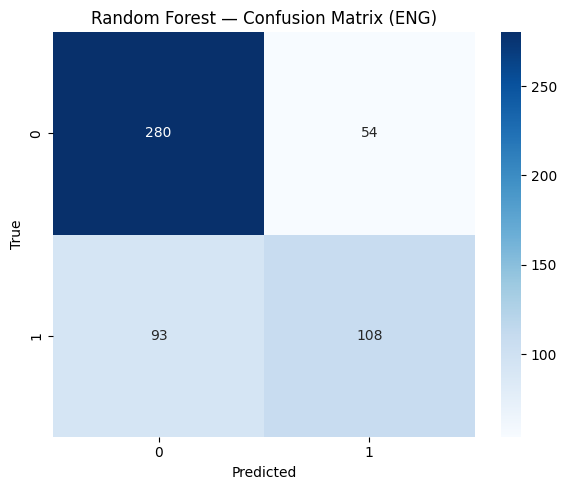


🌍 EVALUATION FOR: DEU
Accuracy: 0.6478 | Macro F1: 0.6465


,precision,recall,f1-score,support
Non-Polarized,0.661765,0.673653,0.667656,334.000000
Polarized,0.631757,0.619205,0.625418,302.000000
accuracy,0.647799,0.647799,0.647799,0.647799
macro avg,0.646761,0.646429,0.646537,636.000000
weighted avg,0.647516,0.647799,0.647600,636.000000


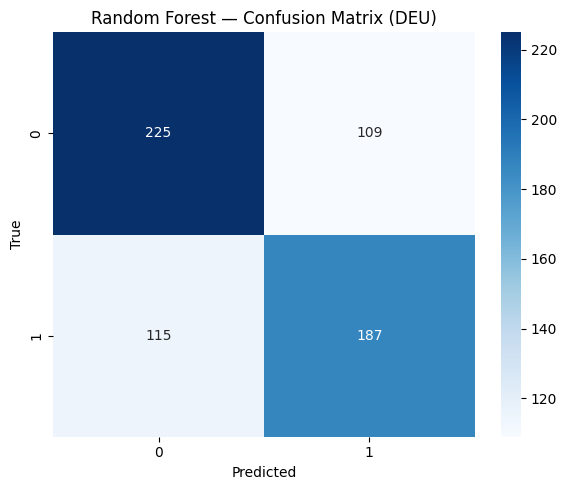


🌍 EVALUATION FOR: SPA
Accuracy: 0.6868 | Macro F1: 0.6858


,precision,recall,f1-score,support
Non-Polarized,0.664865,0.747720,0.703863,329.000000
Polarized,0.714777,0.626506,0.667737,332.000000
accuracy,0.686838,0.686838,0.686838,0.686838
macro avg,0.689821,0.687113,0.685800,661.000000
weighted avg,0.689934,0.686838,0.685718,661.000000


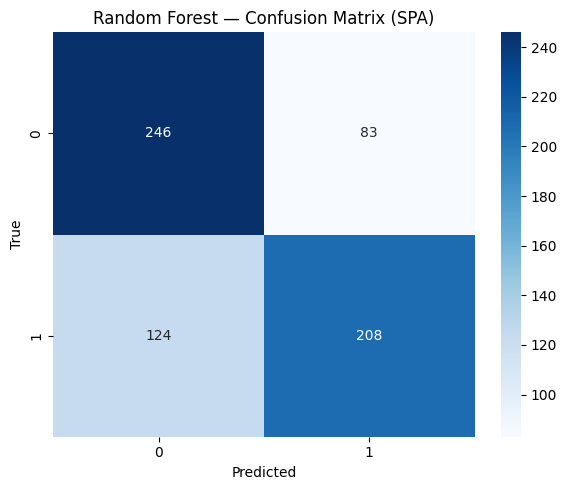

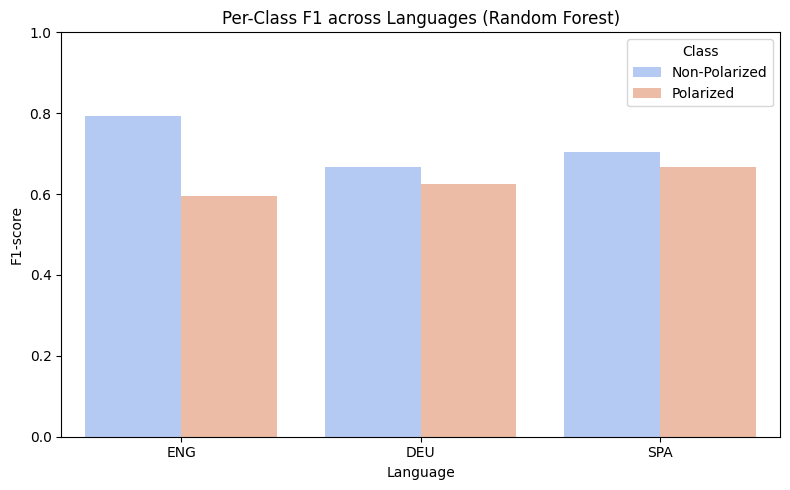

In [20]:


# Evaluate per language
for lang, (train_df, test_df) in datasets.items():
    print(f"\n EVALUATION FOR: {lang.upper()}")

    # Load model & vectorizer
    rf_model = joblib.load(f"results/random_forest_{lang}.pkl")
    vectorizer = joblib.load(f"results/tfidf_vectorizer_{lang}.pkl")

    # Prepare test data
    test_texts = test_df["text"].astype(str)
    y_test = test_df["polarization"]
    X_test_tfidf = vectorizer.transform(test_texts)

    # Predictions
    y_pred = rf_model.predict(X_test_tfidf)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f} | Macro F1: {macro_f1:.4f}")

    # Per-class report
    report = classification_report(
        y_test, y_pred,
        target_names=["Non-Polarized", "Polarized"],
        output_dict=True
    )
    report_df = pd.DataFrame(report).transpose()
    display(report_df[["precision", "recall", "f1-score", "support"]])

    # Save per-class results in CSV
    report_df.to_csv(f"results/random_forest_per_class_{lang}.csv")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Random Forest — Confusion Matrix ({lang.upper()})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# per-class F1 for all languages
all_f1 = []

for lang in datasets.keys():
    report_df = pd.read_csv(f"results/random_forest_per_class_{lang}.csv", index_col=0)
    all_f1.append({
        "Language": lang.upper(),
        "Class": "Non-Polarized",
        "F1": report_df.loc["Non-Polarized", "f1-score"]
    })
    all_f1.append({
        "Language": lang.upper(),
        "Class": "Polarized",
        "F1": report_df.loc["Polarized", "f1-score"]
    })

# Convert to DataFramE
all_f1_df = pd.DataFrame(all_f1)

# Combined bar plot
plt.figure(figsize=(8,5))
sns.barplot(data=all_f1_df, x="Language", y="F1", hue="Class", palette="coolwarm")
plt.ylim(0,1)
plt.title("Per-Class F1 across Languages (Random Forest)")
plt.ylabel("F1-score")
plt.tight_layout()
plt.savefig("plots/random_forest_per_class_all_languages.pdf")  # Save as PDF
plt.show()
